In [2]:
import pandas as pd
import re
import seaborn as sns

%matplotlib inline
sns.set_context("notebook")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, multilabel_confusion_matrix, hamming_loss, zero_one_loss, precision_recall_fscore_support

# Modèle Forêt aléatoire final

In [3]:
### Chargement des données
df = pd.read_csv("../../data/prepared_data/dataset.csv")
print(df.head(10))

# Division en features/cibles
labels_cols = [col for col in df.columns if re.match("comp[1-4]$",col)]
drop_cols = labels_cols+["machineID","total_error","model", "total_failure","datetime"]
X = df.drop(columns=drop_cols)
Y = df[labels_cols]

# Division du dataset en données d'entrainement et de validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=1)


# composant 1
#X1_train = X.drop(columns=["comp2_delay","comp3_delay","comp4_delay"])
y1_train = Y_train["comp1"]
y1_test = Y_test["comp1"]

# Composant 2
#X2 = X.drop(columns=["comp1_delay","comp3_delay","comp4_delay"])
y2_train = Y_train["comp2"]
y2_test = Y_test["comp2"]

# Composant 3
#X3 = X.drop(columns=["comp1_delay","comp2_delay","comp4_delay"bbb])
y3_train = Y_train["comp3"]
y3_test = Y_test["comp3"]

# Composant 4
#X4 = X.drop(columns=["comp1_delay","comp2_delay","comp3_delay"])
y4_train = Y_train["comp4"]
y4_test = Y_test["comp4"]


   machineID             datetime  error1  error2  error3  error4  error5  \
0          1  2015-01-02 06:00:00     0.0     0.0     0.0     0.0     0.0   
1          1  2015-01-03 06:00:00     0.0     0.0     0.0     0.0     0.0   
2          1  2015-01-04 06:00:00     1.0     0.0     1.0     0.0     1.0   
3          1  2015-01-05 06:00:00     0.0     0.0     0.0     0.0     0.0   
4          1  2015-01-06 06:00:00     0.0     0.0     0.0     0.0     0.0   
5          1  2015-01-07 06:00:00     0.0     0.0     0.0     0.0     0.0   
6          1  2015-01-08 06:00:00     0.0     0.0     0.0     0.0     0.0   
7          1  2015-01-09 06:00:00     0.0     0.0     0.0     0.0     0.0   
8          1  2015-01-10 06:00:00     0.0     0.0     0.0     0.0     0.0   
9          1  2015-01-11 06:00:00     0.0     0.0     0.0     1.0     0.0   

   total_error  comp1_delay  comp2_delay  ...  age  model1  model2  model3  \
0          0.0         20.0        215.0  ...   18       0       0       1

## Entrainement des classifieurs RandomForest 

Le score 

$F_2 = 5 \cdot \frac{\rm precision \cdot recall}{(4 \rm \cdot precision)+ \rm recall} = \frac{TP}{TP + 0.8 FN + 0.2FP}$



In [4]:
clfs = []
preds = []
i = 1

for comp in Y_train.columns:
    print(f"\n\n ####COMPOSANT#### {i}\n\n")
    i+=1

    #################
    #   GRID SEARCH
    ################
    
    # Hyperparamètres à tester
    n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 10)]+[150,200]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    # Création de la grille d'hyperparamètres
    param_grid = {'n_estimators': n_estimators,
                  # 'max_features': max_features,
                  # 'max_depth': max_depth,
                  # 'min_samples_split': min_samples_split,
                  # 'min_samples_leaf': min_samples_leaf,
                  # 'bootstrap': bootstrap
                 }
    # Métrique de scoring -> F2 (on donne plus d'importance au rappel)
    ftwo_scorer = make_scorer(fbeta_score, beta=2)
    score = ftwo_scorer

    # Création et fit du GridSearchCv
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 5, n_jobs = -1, verbose = 4, scoring= score)
    grid_search.fit(X_train, Y_train[comp])
    
    best_params = grid_search.best_params_
    
    print("\n","Meilleurs hyperparamètres : ",grid_search.best_params_,'\n')
    
    print("\n","F2-score :", grid_search.best_score_)
    
    # On sauvegarde le modèle entrainé
    clfs.append(grid_search)
    
    ##############
    # Prédictions
    ##############
    y_pred = grid_search.predict(X_test)
    
    preds.append(y_pred)



 ####COMPOSANT#### 1


Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Meilleurs hyperparamètres :  {'n_estimators': 55} 


 F2-score : 0.9712242101869762


 ####COMPOSANT#### 2


Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Meilleurs hyperparamètres :  {'n_estimators': 20} 


 F2-score : 1.0


 ####COMPOSANT#### 3


Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Meilleurs hyperparamètres :  {'n_estimators': 73} 


 F2-score : 1.0


 ####COMPOSANT#### 4


Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Meilleurs hyperparamètres :  {'n_estimators': 20} 


 F2-score : 1.0


In [5]:
preds = pd.DataFrame(np.array(preds).T,columns=["comp1","comp2","comp3","comp4"])

## Evaluation des performances

#### Matrices de confusion pour chaque label

In [6]:
cfs = multilabel_confusion_matrix(Y_test,preds)

In [7]:
def plot_confusion_matrix(cf_matrix, title):
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, annot_kws={"fontsize":21},fmt="")
    plt.title(title)

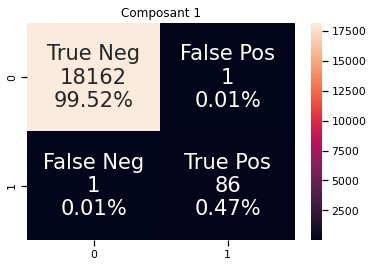

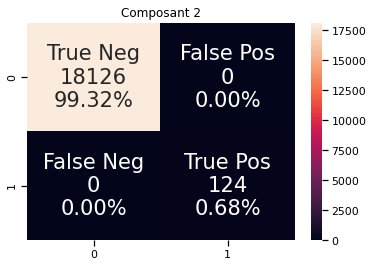

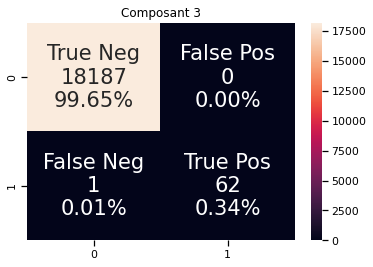

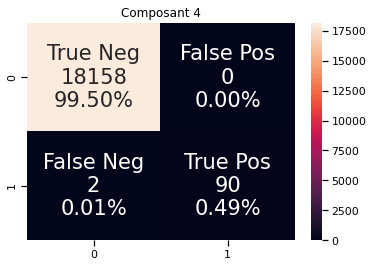

In [8]:
for i, cf in enumerate(cfs):
    plt.figure()
    plot_confusion_matrix(cf,f"Composant {i+1:d}")

#### Hamming-loss

La fonction hamming-loss renvoie la moyenne des distances de Hamming entre chaque paire de vecteurs.

La distance de Hamming est défini par :

$$L_{\rm Hamming} (y_{\rm true},y_{\rm pred}) = \frac{1}{n_{\rm labels}} \sum_{j=0}^{n_{\rm labels} -1} 1(y_{\rm true,\it i} \neq y_{\rm pred,\it i})$$

Si on a prédit $y_{\rm pred}=[0,0,1,0]$ pour $y_{\rm true}=[0,0,0,0]$ alors $L_{\rm Hamming}= 0.25$

In [9]:
hamming_loss(Y_test,preds)

6.84931506849315e-05

#### Zero-one-loss


Pour chaque échantillon, la fonction zero_one_loss considère que la prédiction est bonne si toutes les étiquettes sont correctement prédites. On compte 0 si c'est le cas 1 sinon.
La moyenne de ces valeurs est renvoyée.

Si on a prédit $y_{\rm pred}=[0,0,1,0]$ pour $y_{\rm true}=[0,0,0,0]$ alors $L_{\rm zero-one}= 1$

In [10]:
zero_one_loss(Y_test,preds)

0.0002739726027397582

In [11]:
precision_recall_fscore_support(Y_test,preds,beta=2.0)

(array([0.98850575, 1.        , 1.        , 1.        ]),
 array([0.98850575, 1.        , 0.98412698, 0.97826087]),
 array([0.98850575, 1.        , 0.98726115, 0.98253275]),
 array([ 87, 124,  63,  92]))

## Quelles features sont importantes pour la prédiction ?

### Composant 1

In [24]:
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(n_estimators=55)
#rf.fit(X_train,Y_train["comp1"])
# Composant 1
select = SelectFromModel(rf,threshold=0.003)
select.fit(X_train,Y_train["comp1"])

SelectFromModel(estimator=RandomForestClassifier(n_estimators=55),
                threshold=0.003)

In [25]:
X_train2 = select.transform(X_train)

In [26]:
select.get_feature_names_out(select.feature_names_in_)

array(['error1', 'comp1_delay', 'comp2_delay', 'comp3_delay',
       'comp4_delay', 'volt_mean', 'volt_std', 'rotate_mean',
       'rotate_std', 'pressure_mean', 'pressure_std', 'vibration_mean',
       'vibration_std', 'age', 'model3'], dtype=object)

### Composant 2

In [30]:
# Composant 2

select = SelectFromModel(rf)
select.fit(X_train,Y_train["comp2"])
select.get_feature_names_out(select.feature_names_in_)

array(['error2', 'error3', 'comp2_delay', 'rotate_mean'], dtype=object)

### Composant 3

In [31]:
# Composant 3


select = SelectFromModel(rf)
select.fit(X_train,Y_train["comp3"])
select.get_feature_names_out(select.feature_names_in_)

array(['error4', 'comp3_delay', 'comp4_delay', 'pressure_mean'],
      dtype=object)

### Composant 4

In [33]:
# Composant 4

select = SelectFromModel(rf)
select.fit(X_train,Y_train["comp4"])
select.get_feature_names_out(select.feature_names_in_)

array(['error5', 'comp4_delay', 'vibration_mean'], dtype=object)